<a href="https://colab.research.google.com/github/helloitsdaksh/Transformer_from_Scratch/blob/main/Decoder_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightning torchinfo torchviz torchview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch ## torch let's us create tensors and also provides helper functions
import torch.nn as nn ## torch.nn gives us nn.Module(), nn.Embedding() and nn.Linear()
import torch.nn.functional as F # This gives us the softmax() and argmax()
from torch.optim import Adam ## We will use the Adam optimizer, which is, essentially,
                             ## a slightly less stochastic version of stochastic gradient descent.
from torch.utils.data import TensorDataset, DataLoader ## We'll store our data in DataLoaders

import lightning as L ## Lightning makes it easier to write, optimize and scale our code

In [120]:
import torch
import re
from torch.utils.data import Dataset, DataLoader

# **Define Constants** #
# ABIT COMPLEX
# BLOCK_SIZE = 8  # Context window size
# BATCH_SIZE = 4  # Number of sequences per batch (B)
# MAX_LEN = 10  # Maximum sequence length for positional encoding (T)
# N_EMBD = 8  # Embedding dimension (C) d_model
# NUM_HEADS = 4 # 2 heads
# HEAD_SIZE = N_EMBD // NUM_HEADS  # Each head gets a fraction of embedding size
# DROPOUT_RATE = 0.2
# NUM_LAYERS = 5
# LEARNING_RATE = 0.0001

#SIMPLE MODEL
BLOCK_SIZE = 4 # Context window size
BATCH_SIZE = 4  # Number of sequences per batch (B)
MAX_LEN = 4  # Maximum sequence length for positional encoding (T)
N_EMBD = 2  # Embedding dimension (C) d_model
NUM_HEADS = 2 # 2 heads
HEAD_SIZE = N_EMBD // NUM_HEADS  # Each head gets a fraction of embedding size
DROPOUT_RATE = 0.1
NUM_LAYERS = 2
LEARNING_RATE = 0.0001


# Sample Text
text = """<SOS> I Love Transformers <EOS>"""

# Correct regex pattern
word_tokens = re.findall(r"<EOS>|<SOS>|[\w]+|[^\w\s]", text)
SPECIAL_TOKENS = ["<PAD>", "<SOS>", "<EOS>"]
word_tokens.extend(SPECIAL_TOKENS)  # Add special tokens

# **Create Vocabulary**
token_to_id = {w: i for i, w in enumerate(sorted(set(word_tokens)))}
id_to_token = {i: w for w, i in token_to_id.items()}

# **Update VOCAB_SIZE Dynamically**
VOCAB_SIZE = len(token_to_id)  # Now we set the actual vocab size

# **Encode Text as Token IDs**
encoded_data = torch.tensor([token_to_id[w] for w in word_tokens], dtype=torch.long)

# **Train-Validation Split**
n = int(0.9 * len(encoded_data))
train_data = encoded_data[:n]
# val_data = encoded_data[n:]

print(f"Vocabulary Size: {VOCAB_SIZE}")
print(f"Context Window Size (BLOCK_SIZE): {BLOCK_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Sequence Length: {MAX_LEN}")
print(f"Embedding Dimension (N_EMBD): {N_EMBD}")

# **Custom Dataset Class**
class WordDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data) - BLOCK_SIZE  # Ensure valid sequences

    def __getitem__(self, idx):
        x = self.data[idx : idx + BLOCK_SIZE]  # Context window
        y = self.data[idx + 1 : idx + BLOCK_SIZE + 1]  # Next word target

        # Pad sequences to match MAX_LEN
        pad_token = token_to_id["<PAD>"]
        x_padded = torch.cat([x, torch.full((MAX_LEN - len(x),), pad_token, dtype=torch.long)], dim=0)
        y_padded = torch.cat([y, torch.full((MAX_LEN - len(y),), pad_token, dtype=torch.long)], dim=0)

        return x_padded, y_padded

# **Create DataLoader**
train_dataset = WordDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# val_dataset = WordDataset(val_data)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# **Test DataLoader**
sample_x, sample_y = next(iter(train_loader))

print("\nSample Input Batch (x):", sample_x)
print("Decoded x:", [[id_to_token[i.item()] for i in row] for row in sample_x])

print("\nSample Target Batch (y):", sample_y)
print("Decoded y:", [[id_to_token[i.item()] for i in row] for row in sample_y])

Vocabulary Size: 6
Context Window Size (BLOCK_SIZE): 4
Batch Size: 4
Max Sequence Length: 4
Embedding Dimension (N_EMBD): 2

Sample Input Batch (x): tensor([[4, 5, 0, 1],
        [3, 4, 5, 0],
        [2, 3, 4, 5]])
Decoded x: [['Love', 'Transformers', '<EOS>', '<PAD>'], ['I', 'Love', 'Transformers', '<EOS>'], ['<SOS>', 'I', 'Love', 'Transformers']]

Sample Target Batch (y): tensor([[5, 0, 1, 2],
        [4, 5, 0, 1],
        [3, 4, 5, 0]])
Decoded y: [['Transformers', '<EOS>', '<PAD>', '<SOS>'], ['Love', 'Transformers', '<EOS>', '<PAD>'], ['I', 'Love', 'Transformers', '<EOS>']]


# Position Embeddings

In [121]:
import torch
import torch.nn as nn
from torch.fx import symbolic_trace
from torchinfo import summary

# **Position Encoding Class**
class PositionEncoding(nn.Module):
    def __init__(self, n_embd=N_EMBD, max_len=MAX_LEN):
        super().__init__()

        # Position encoding matrix: (T, C)
        pe = torch.zeros(max_len, N_EMBD)
        # print(f"Position Encoding Matrix (Before Training):\n{pe}\n")
        # Position indices: (T, 1)
        position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)
        # print(f"Position Indices (Before Training):\n{position}\n")

        # Embedding index: (C/2) for sine/cosine calculation
        embedding_index = torch.arange(start=0, end=N_EMBD, step=2).float()
        # print(f"Embedding Index (Before Training):\n{embedding_index}\n")

        # Compute division term: (C/2)
        div_term = 1 / torch.tensor(10000.0) ** (embedding_index / N_EMBD)
        # print(f"Division Term (Before Training):\n{div_term}\n")

        # Compute sine for even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # print(f"Sine Matrix:\n{pe[:, 0::2]}\n")

        # Compute cosine for odd indices
        pe[:, 1::2] = torch.cos(position * div_term)
        # print(f"Cosine Matrix:\n{pe[:, 1::2]}\n")

        # Print final positional encoding matrix for verification
        # print(f"Final position encoding matrix:\n{pe}\n")

        # Store position encodings without making them trainable
        self.register_buffer('pe', pe)

    def forward(self, word_embeddings):
        """
        Adds positional encoding to word embeddings.
        Shapes:
        - word_embeddings: (B, T, C)
        - position encoding: (T, C) → Needs to be reshaped for broadcasting
        - final output: (B, T, C)
        """
        return word_embeddings + self.pe[:word_embeddings.size(1), :].unsqueeze(0)
        # Ensures (B, T, C) + (1, T, C) for correct broadcasting

# **Position Embedding Helper**
def position_embedding_helper(sample_x):
    we = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=N_EMBD)
    pe = PositionEncoding(n_embd=N_EMBD, max_len=MAX_LEN)

    word_embeddings = we(sample_x)  # Shape: (B, T, N_EMBD)
    print(f"\n[Word Embeddings (Before Position Encoding)]\nShape: {word_embeddings.shape}\n{word_embeddings}\n")

    # Apply Position Encoding
    position_encoded_embeddings = pe(word_embeddings)

    print(f"\n[Final Position-Encoded Word Embeddings]\nShape: {position_encoded_embeddings.shape}\n{position_encoded_embeddings}\n")


def position_embedding_graph():
    from torchview import draw_graph
    pe_model = PositionEncoding(n_embd=N_EMBD, max_len=MAX_LEN)
    input_size = (BATCH_SIZE, MAX_LEN, N_EMBD)
    model_graph = draw_graph(pe_model, input_size=input_size, expand_nested=True)
    return model_graph

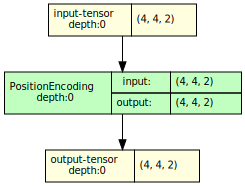

In [122]:
model_graph = position_embedding_graph()
model_graph.visual_graph

In [123]:
position_embedding_helper(sample_x)


[Word Embeddings (Before Position Encoding)]
Shape: torch.Size([3, 4, 2])
tensor([[[-1.2776, -0.6300],
         [ 0.2694,  0.7482],
         [ 0.0859,  0.1861],
         [ 0.6757,  0.1313]],

        [[ 2.1010,  1.4371],
         [-1.2776, -0.6300],
         [ 0.2694,  0.7482],
         [ 0.0859,  0.1861]],

        [[ 0.0182, -2.2498],
         [ 2.1010,  1.4371],
         [-1.2776, -0.6300],
         [ 0.2694,  0.7482]]], grad_fn=<EmbeddingBackward0>)


[Final Position-Encoded Word Embeddings]
Shape: torch.Size([3, 4, 2])
tensor([[[-1.2776,  0.3700],
         [ 1.1109,  1.2885],
         [ 0.9952, -0.2301],
         [ 0.8168, -0.8587]],

        [[ 2.1010,  2.4371],
         [-0.4361, -0.0897],
         [ 1.1787,  0.3321],
         [ 0.2270, -0.8039]],

        [[ 0.0182, -1.2498],
         [ 2.9425,  1.9774],
         [-0.3683, -1.0461],
         [ 0.4106, -0.2418]]], grad_fn=<AddBackward0>)



# Attention

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# **Single Attention Head**
class Head(nn.Module):
    """Single self-attention head for Multi-Head Attention.

    Args:
        head_size (int): The size of each attention head (N_EMBD / NUM_HEADS).
        dropout (float, optional): Dropout rate for regularization. Defaults to DROPOUT_RATE.

    Attributes:
        W_q (nn.Linear): Linear transformation for query matrix.
        W_k (nn.Linear): Linear transformation for key matrix.
        W_v (nn.Linear): Linear transformation for value matrix.
        scale (float): Scaling factor for dot-product attention.
        dropout (nn.Dropout): Dropout layer for attention scores.
    """

    def __init__(self, head_size, dropout=DROPOUT_RATE):
        super().__init__()
        self.W_q = nn.Linear(in_features=N_EMBD, out_features=head_size, bias=False)
        self.W_k = nn.Linear(in_features=N_EMBD, out_features=head_size, bias=False)
        self.W_v = nn.Linear(in_features=N_EMBD, out_features=head_size, bias=False)

        self.scale = head_size ** -0.5  # Scale factor for dot-product attention
        self.dropout = nn.Dropout(dropout)  # Optional dropout
        # print(f"Dropout Rate Passed: {dropout}")

    def forward(self, x, mask=None):
        B, T, C = x.shape  # Batch, Sequence Length, Embedding Dimension
        # print(f"[HEAD] Input Shape: {x.shape} \n Input Matrix: {x}")

        # Compute Q, K, V
        q = self.W_q(x)  # (B, T, HEAD_SIZE)
        k = self.W_k(x)  # (B, T, HEAD_SIZE)
        v = self.W_v(x)  # (B, T, HEAD_SIZE)
        # print(f"\n[HEAD] Q Matrix: {q}")
        # print(f"[HEAD] K Matrix: {k}")
        # print(f"[HEAD] V Matrix: {v}")

        # Compute scaled dot-product attention scores
        sims = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # (B, T, T)
        # print(f"\n[HEAD] Attention Scores Matrix: {sims}")

        # Apply mask if provided
        if mask is not None:
            sims = sims.masked_fill(mask == 0, float('-inf'))

        # Apply softmax to get attention weights
        attention_weights = F.softmax(sims, dim=-1)  # (B, T, T)
        attention_weights = self.dropout(attention_weights)
        # print(f"\n[HEAD] Attention Weights Matrix: {attention_weights}")

        # Compute weighted sum of values
        out = torch.matmul(attention_weights, v)  # (B, T, HEAD_SIZE)
        # print(f"\n[HEAD] Output Matrix: {out}")

        return out

# **Multi-Head Attention**
class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention mechanism.

    Args:
        num_heads (int): Number of attention heads.
        dropout (float, optional): Dropout rate. Defaults to DROPOUT_RATE.

    Attributes:
        num_heads (int): Number of heads.
        head_size (int): Size of each attention head (N_EMBD / num_heads).
        heads (nn.ModuleList): List of `Head` modules for self-attention.
        proj (nn.Linear): Final linear projection layer.
        dropout (nn.Dropout): Dropout layer applied after projection.
    """

    def __init__(self, num_heads=NUM_HEADS, dropout=DROPOUT_RATE):
        super().__init__()
        # print(f"Dropout Rate Passed: {dropout}")

        self.num_heads = num_heads
        self.head_size = HEAD_SIZE  # Compute individual head size

        # Create multiple attention heads
        self.heads = nn.ModuleList([Head(self.head_size, dropout) for _ in range(num_heads)])

        # Final projection layer
        self.proj = nn.Linear(N_EMBD, N_EMBD)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None,):
        """


        """

        # print(f"\n[MHA] Input Shape: {x.shape}")
        # Compute attention for each head independently
        heads_output = [h(x, mask) for h in self.heads]  # List of (B, T, head_size) tensors
        # print(f"\n[MHA] Heads Output: {heads_output}")

        # Concatenate head outputs across embedding dimension
        out = torch.cat(heads_output, dim=-1)   # (B, T, N_EMBD)
        # print(f"\n[MHA] Concatenated Heads Output: {out}")

        # Apply final projection layer
        out = self.proj(out)  # (B, T, N_EMBD)
        # print(f"\n[MHA] Final Output After Projection: {out}")

        out = self.dropout(out)  # Apply dropout
        # print(f"\n[MHA] Final Output After Dropout: {out}")

        return out

# **Multi-Head Attention Helper**
def multi_head_attention_helper(sample_x):
    """
    Helper function to test Multi-Head Attention.
    """
    we = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=N_EMBD)
    pe = PositionEncoding(n_embd=N_EMBD, max_len=MAX_LEN)

    word_embeddings = we(sample_x)  # Shape: (B, T, N_EMBD)
    position_encoded_embeddings = pe(word_embeddings)

    mha = MultiHeadAttention(NUM_HEADS)
    output = mha(position_encoded_embeddings)

    print(summary(mha))


def multi_head_attention_graph():
    from torchview import draw_graph
    mha_model = MultiHeadAttention(num_heads=NUM_HEADS, dropout=DROPOUT_RATE)
    input_size = (BATCH_SIZE, MAX_LEN, N_EMBD)
    model_graph = draw_graph(mha_model, input_size=input_size, expand_nested=True)
    return model_graph



In [125]:
multi_head_attention_helper(sample_x)


Layer (type:depth-idx)                   Param #
MultiHeadAttention                       --
├─ModuleList: 1-1                        --
│    └─Head: 2-1                         --
│    │    └─Linear: 3-1                  2
│    │    └─Linear: 3-2                  2
│    │    └─Linear: 3-3                  2
│    │    └─Dropout: 3-4                 --
│    └─Head: 2-2                         --
│    │    └─Linear: 3-5                  2
│    │    └─Linear: 3-6                  2
│    │    └─Linear: 3-7                  2
│    │    └─Dropout: 3-8                 --
├─Linear: 1-2                            6
├─Dropout: 1-3                           --
Total params: 18
Trainable params: 18
Non-trainable params: 0


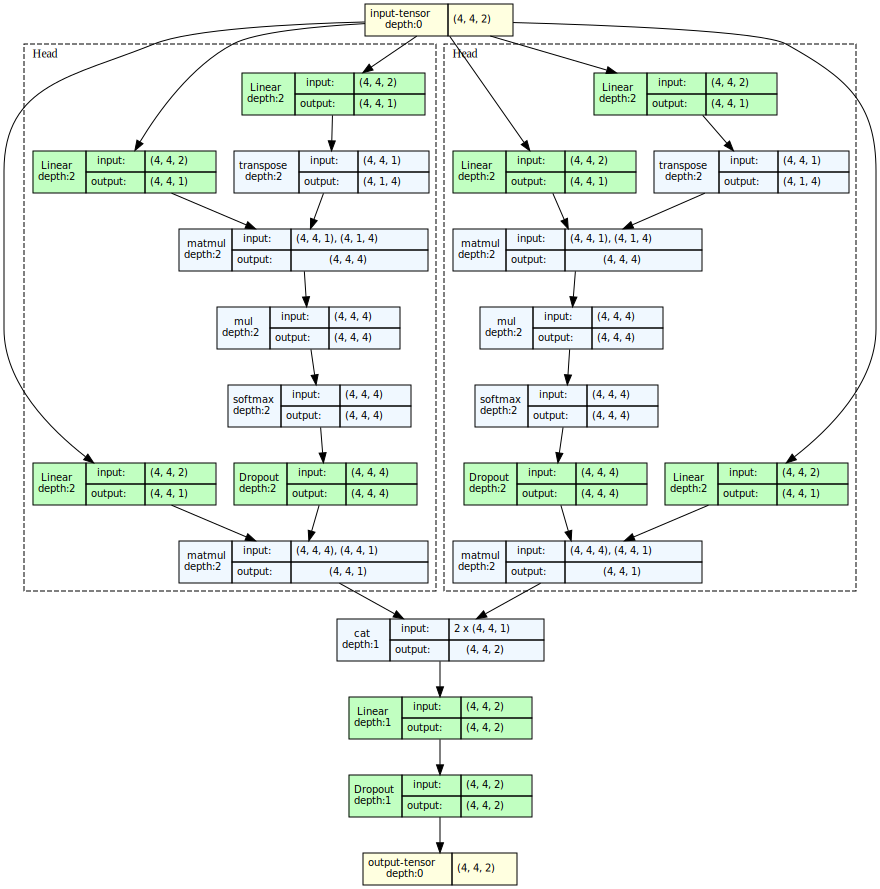

In [126]:
model_graph = multi_head_attention_graph()
model_graph.visual_graph


# Putting it all together

In [139]:
import torch
import torch.nn as nn
import pytorch_lightning as L
from torch.optim import Adam

class FeedFoward(nn.Module):
    """A simple 2-layer feed-forward network with ReLU activation.

    Args:
        N_EMBD (int): Embedding dimension.
        dropout (float): Dropout rate for regularization.
    """

    def __init__(self, N_EMBD, dropout=DROPOUT_RATE):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=N_EMBD, out_features=4 * N_EMBD),
            nn.ReLU(),
            nn.Linear(in_features=4 * N_EMBD, out_features=N_EMBD),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        """Forward pass for the feed-forward network.

        Args:
            x (torch.Tensor): Input tensor of shape (B, T, N_EMBD).

        Returns:
            torch.Tensor: Output tensor of the same shape as input.
        """
        return self.net(x)

class Block(nn.Module):
    """A single Transformer block containing Multi-Head Attention and Feed-Forward layers.

    Args:
        N_EMBD (int): Embedding dimension.
        HEAD_SIZE (int): Size of each attention head.
        dropout (float): Dropout rate for regularization.
    """

    def __init__(self, N_EMBD, HEAD_SIZE, dropout=DROPOUT_RATE):
        super().__init__()
        self.sa = MultiHeadAttention(NUM_HEADS)  # Multi-Head Attention layer
        self.ffwd = FeedFoward(N_EMBD, dropout)  # Feed-Forward Network
        self.ln1 = nn.LayerNorm(N_EMBD)  # Layer Normalization before MHA
        self.ln2 = nn.LayerNorm(N_EMBD)  # Layer Normalization before Feed-Forward

    def forward(self, x):
        """Forward pass of the Transformer block.

        Args:
            x (torch.Tensor): Input tensor of shape (B, T, N_EMBD).

        Returns:
            torch.Tensor: Output tensor of the same shape as input.
        """
        x = x + self.sa(self.ln1(x))  # Add residual connection
        x = x + self.ffwd(self.ln2(x))  # Add residual connection
        return x

class DecoderOnlyTransformer(L.LightningModule):
    """A GPT-style decoder-only Transformer for text generation.

    Args:
        num_tokens (int): Vocabulary size.
        n_embd (int): Embedding dimension.
        num_heads (int): Number of attention heads.
        num_layers (int): Number of Transformer blocks.
        max_len (int): Maximum sequence length.
        dropout (float): Dropout rate for regularization.
        learning_rate (float): Learning rate for optimization.
    """

    def __init__(self, num_tokens=VOCAB_SIZE, n_embd=N_EMBD, num_heads=NUM_HEADS, num_layers=NUM_LAYERS, max_len=MAX_LEN, dropout=DROPOUT_RATE, learning_rate=0.001):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        L.seed_everything(seed=42)

        # Hyperparameters for logging
        self.save_hyperparameters()

        # Embedding Layers
        self.token_embedding = nn.Embedding(num_embeddings=num_tokens, embedding_dim=n_embd)
        self.position_encoding = PositionEncoding(n_embd=n_embd, max_len=max_len)

        # Transformer Blocks
        self.blocks = nn.Sequential(*[Block(n_embd, num_heads, dropout) for _ in range(num_layers)])

        # Final Layer Norm & Output Projection
        self.ln_f = nn.LayerNorm(N_EMBD)
        self.fc_layer = nn.Linear(N_EMBD, num_tokens)

        # Loss Function
        self.loss = nn.CrossEntropyLoss()

    def forward(self, token_ids, targets=None):
        """Forward pass of the Decoder Transformer.

        Args:
            token_ids (torch.Tensor): Input tensor of token IDs (B, T).
            targets (torch.Tensor, optional): Target token IDs for loss calculation.

        Returns:
            tuple: (logits, loss) where:
                - logits (torch.Tensor): Model predictions of shape (B, T, num_tokens).
                - loss (torch.Tensor or None): Cross-entropy loss if targets are provided.
        """
        B, T = token_ids.shape  # Batch size, sequence length

        # Token & Position Embeddings
        tok_emb = self.token_embedding(token_ids)  # (B, T, N_EMBD)
        pos_emb = self.position_encoding(tok_emb)  # (B, T, N_EMBD)

        # Apply Transformer Blocks
        x = self.blocks(pos_emb)  # (B, T, N_EMBD)
        x = self.ln_f(x)  # (B, T, N_EMBD)

        # Compute Logits
        logits = self.fc_layer(x)  # (B, T, num_tokens)

        # Compute Loss if Targets are Given
        loss = None
        if targets is not None:
            logits = logits.view(B * T, -1)  # Reshape logits to (B*T, num_tokens)
            targets = targets.view(B * T)  # Reshape targets to (B*T)
            loss = self.loss(logits, targets)

        return logits, loss

    def configure_optimizers(self):
        """Configures the optimizer for training.

        Returns:
            torch.optim.Adam: Adam optimizer with the given learning rate.
        """
        return Adam(self.parameters(), lr=self.hparams.learning_rate)

    def training_step(self, batch, batch_idx):
        """Performs a single training step.

        Args:
            batch (tuple): Input tokens and target tokens.
            batch_idx (int): Batch index (not used).

        Returns:
            torch.Tensor: Training loss.
        """
        input_tokens, labels = batch  # Collect input
        logits, loss = self.forward(input_tokens, labels)  # Forward pass
        self.log("train_loss", loss, prog_bar=True)  # Log loss to progress bar
        return loss

    def validation_step(self, batch, batch_idx):
        """Performs a single validation step.

        Args:
            batch (tuple): Input tokens and target tokens.
            batch_idx (int): Batch index (not used).

        Returns:
            torch.Tensor: Validation loss.
        """
        input_tokens, labels = batch
        logits, loss = self.forward(input_tokens, labels)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)  # Log validation loss
        return loss

def transformer_graph():
    from torchview import draw_graph
    model = DecoderOnlyTransformer(
        num_tokens=VOCAB_SIZE,
        n_embd=N_EMBD,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        max_len=MAX_LEN,
        dropout=DROPOUT_RATE,
        learning_rate=LEARNING_RATE
    )

    # Define dummy input (batch_size=4, sequence_length=6)
    dummy_input = torch.randint(0, VOCAB_SIZE, (BATCH_SIZE, MAX_LEN))
    model_graph = draw_graph(model, input_data=(dummy_input,), expand_nested=True)
    return model_graph


INFO:lightning_fabric.utilities.seed:Seed set to 42


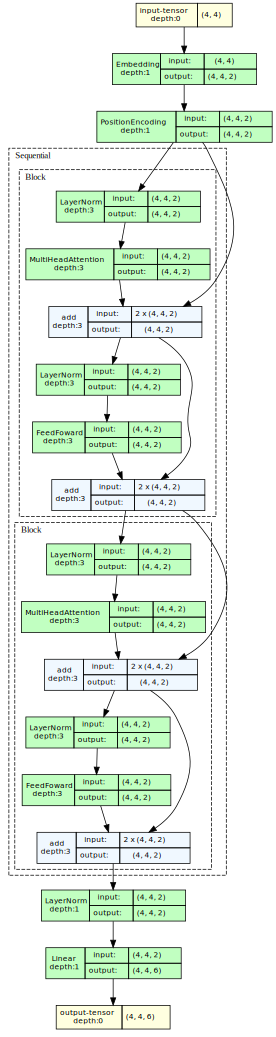

In [140]:
model_graph = transformer_graph()
model_graph.visual_graph

# Training and Generation

In [130]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DecoderOnlyTransformer(num_tokens=VOCAB_SIZE)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [131]:
def generate_text(model, seed_text, max_new_tokens=10):
    """
    Generate text using trained model.

    Args:
        model: Trained Transformer model.
        seed_text: Input text to start generation.
        max_new_tokens: Number of new tokens to generate.

    Returns:
        Generated text.
    """
    model.eval()  # Set model to evaluation mode

    # Convert input text to token IDs
    input_tokens = torch.tensor([token_to_id[word] for word in seed_text.split() if word in token_to_id], dtype=torch.long).unsqueeze(0)
    input_tokens = input_tokens.to(model.device)

    for _ in range(max_new_tokens):
        logits, _ = model(input_tokens)  # Get model output
        next_token = torch.argmax(logits[:, -1, :], dim=-1)  # Get highest probability token
        input_tokens = torch.cat([input_tokens, next_token.unsqueeze(0)], dim=1)  # Append to input

    generated_words = [id_to_token[i.item()] for i in input_tokens.squeeze()]
    return " ".join(generated_words)

In [132]:
# Get a sample batch from DataLoader
sample_x, sample_y = next(iter(train_loader))

# Ensure the input is moved to the same device as the model
sample_x, sample_y = sample_x.to(model.device), sample_y.to(model.device)

# Perform a forward pass
logits, loss = model(sample_x, sample_y)

print(f"Output Logits Shape: {logits.shape}")  # Expected: (BATCH_SIZE, MAX_LEN, VOCAB_SIZE)
print(f"Loss: {loss.item() if loss is not None else 'No Loss Computed'}")

Output Logits Shape: torch.Size([12, 6])
Loss: 2.2246792316436768


In [137]:
# Define Trainer
trainer = L.Trainer(max_epochs=30, accelerator="cuda")  # Set to "gpu" if CUDA is available

# Train Model
trainer.fit(model, train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type             | Params | Mode
--------------------------------------------------------------
0 | dropout           | Dropout          | 0      | eval
1 | token_embedding   | Embedding        | 12     | eval
2 | position_encoding | PositionEncoding | 0      | eval
3 | blocks            | Sequential       | 136    | eval
4 | ln_f              | LayerNorm        | 4      | eval
5 | fc_layer          | Linear           | 18     | eval
6 | loss             

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [138]:
# Example Inference
seed_text = "I Love"
generated_text = generate_text(model, seed_text, max_new_tokens=2)
print(f"Generated Text: {generated_text}")

Generated Text: I Love Transformers Transformers


#FINAL ARCHITECTURE:

In [134]:
import torch
import torch.nn as nn
from torch.fx import symbolic_trace
from torchinfo import summary

class PositionEncoding(nn.Module):
    def __init__(self, n_embd=N_EMBD, max_len=MAX_LEN):
        super().__init__()
        pe = torch.zeros(max_len, N_EMBD)
        position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)
        embedding_index = torch.arange(start=0, end=N_EMBD, step=2).float()
        div_term = 1 / torch.tensor(10000.0) ** (embedding_index / N_EMBD)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, word_embeddings):
        """
        Adds positional encoding to word embeddings.
        Shapes:
        - word_embeddings: (B, T, C)
        - position encoding: (T, C) → Needs to be reshaped for broadcasting
        - final output: (B, T, C)
        """
        return word_embeddings + self.pe[:word_embeddings.size(1), :].unsqueeze(0)

class Head(nn.Module):
    """Single self-attention head for Multi-Head Attention.

    Args:
        head_size (int): The size of each attention head (N_EMBD / NUM_HEADS).
        dropout (float, optional): Dropout rate for regularization. Defaults to DROPOUT_RATE.

    Attributes:
        W_q (nn.Linear): Linear transformation for query matrix.
        W_k (nn.Linear): Linear transformation for key matrix.
        W_v (nn.Linear): Linear transformation for value matrix.
        scale (float): Scaling factor for dot-product attention.
        dropout (nn.Dropout): Dropout layer for attention scores.
    """

    def __init__(self, head_size, dropout=DROPOUT_RATE):
        super().__init__()
        self.W_q = nn.Linear(in_features=N_EMBD, out_features=head_size, bias=False)
        self.W_k = nn.Linear(in_features=N_EMBD, out_features=head_size, bias=False)
        self.W_v = nn.Linear(in_features=N_EMBD, out_features=head_size, bias=False)

        self.scale = head_size ** -0.5
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, T, C = x.shape
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)
        sims = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        if mask is not None:
            sims = sims.masked_fill(mask == 0, float('-inf'))

        attention_weights = F.softmax(sims, dim=-1)
        attention_weights = self.dropout(attention_weights)
        out = torch.matmul(attention_weights, v)
        return out

class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention mechanism.

    Args:
        num_heads (int): Number of attention heads.
        dropout (float, optional): Dropout rate. Defaults to DROPOUT_RATE.

    Attributes:
        num_heads (int): Number of heads.
        head_size (int): Size of each attention head (N_EMBD / num_heads).
        heads (nn.ModuleList): List of `Head` modules for self-attention.
        proj (nn.Linear): Final linear projection layer.
        dropout (nn.Dropout): Dropout layer applied after projection.
    """

    def __init__(self, num_heads=NUM_HEADS, dropout=DROPOUT_RATE):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = HEAD_SIZE
        self.heads = nn.ModuleList([Head(self.head_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(N_EMBD, N_EMBD)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None,):
        heads_output = [h(x, mask) for h in self.heads]
        out = torch.cat(heads_output, dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out

import torch
import torch.nn as nn
import pytorch_lightning as L
from torch.optim import Adam

class FeedFoward(nn.Module):
    """A simple 2-layer feed-forward network with ReLU activation.

    Args:
        N_EMBD (int): Embedding dimension.
        dropout (float): Dropout rate for regularization.
    """

    def __init__(self, N_EMBD, dropout=DROPOUT_RATE):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=N_EMBD, out_features=4 * N_EMBD),
            nn.ReLU(),
            nn.Linear(in_features=4 * N_EMBD, out_features=N_EMBD),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """A single Transformer block containing Multi-Head Attention and Feed-Forward layers.

    Args:
        N_EMBD (int): Embedding dimension.
        HEAD_SIZE (int): Size of each attention head.
        dropout (float): Dropout rate for regularization.
    """

    def __init__(self, N_EMBD, HEAD_SIZE, dropout=DROPOUT_RATE):
        super().__init__()
        self.sa = MultiHeadAttention(NUM_HEADS)
        self.ffwd = FeedFoward(N_EMBD, dropout)
        self.ln1 = nn.LayerNorm(N_EMBD)
        self.ln2 = nn.LayerNorm(N_EMBD)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class DecoderOnlyTransformer(L.LightningModule):
    """A GPT-style decoder-only Transformer for text generation.

    Args:
        num_tokens (int): Vocabulary size.
        n_embd (int): Embedding dimension.
        num_heads (int): Number of attention heads.
        num_layers (int): Number of Transformer blocks.
        max_len (int): Maximum sequence length.
        dropout (float): Dropout rate for regularization.
        learning_rate (float): Learning rate for optimization.
    """

    def __init__(self, num_tokens=VOCAB_SIZE, n_embd=N_EMBD, num_heads=NUM_HEADS, num_layers=NUM_LAYERS, max_len=MAX_LEN, dropout=DROPOUT_RATE, learning_rate=0.001):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        L.seed_everything(seed=42)
        self.save_hyperparameters()
        self.token_embedding = nn.Embedding(num_embeddings=num_tokens, embedding_dim=n_embd)
        self.position_encoding = PositionEncoding(n_embd=n_embd, max_len=max_len)
        self.blocks = nn.Sequential(*[Block(n_embd, num_heads, dropout) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(N_EMBD)
        self.fc_layer = nn.Linear(N_EMBD, num_tokens)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, token_ids, targets=None):
        B, T = token_ids.shape
        tok_emb = self.token_embedding(token_ids)
        pos_emb = self.position_encoding(tok_emb)
        x = self.blocks(pos_emb)
        x = self.ln_f(x)
        logits = self.fc_layer(x)
        loss = None
        if targets is not None:
            logits = logits.view(B * T, -1)
            targets = targets.view(B * T)
            loss = self.loss(logits, targets)

        return logits, loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.hparams.learning_rate)

    def training_step(self, batch, batch_idx):
        input_tokens, labels = batch
        logits, loss = self.forward(input_tokens, labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_tokens, labels = batch
        logits, loss = self.forward(input_tokens, labels)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss



BLOCK_SIZE = 4 # Context window size
BATCH_SIZE = 4  # Number of sequences per batch (B)
MAX_LEN = 4  # Maximum sequence length for positional encoding (T)
N_EMBD = 2  # Embedding dimension (C) d_model
NUM_HEADS = 2 # 2 heads
HEAD_SIZE = N_EMBD // NUM_HEADS  # Each head gets a fraction of embedding size
DROPOUT_RATE = 0.1
NUM_LAYERS = 2
LEARNING_RATE = 0.0001

trainer = L.Trainer(max_epochs=30, accelerator="cuda")
trainer.fit(model, train_loader)
